In [ ]:
import yfinance as yf

# Fetch historical data for EURUSD
data = yf.download('EURUSD=X', start='2010-01-01', end='2024-01-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,1.432706,1.440196,1.432706,1.438994,1.438994,0
2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0
2010-01-05,1.442710,1.448310,1.435194,1.436596,1.436596,0
2010-01-06,1.436596,1.443460,1.429123,1.440403,1.440403,0
2010-01-07,1.440300,1.444481,1.430206,1.431803,1.431803,0


LSTM


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - RootMeanSquaredError: 0.2502 - loss: 0.0704 - val_RootMeanSquaredError: 0.0342 - val_loss: 0.0012
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - RootMeanSquaredError: 0.0854 - loss: 0.0073 - val_RootMeanSquaredError: 0.0335 - val_loss: 0.0011
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - RootMeanSquaredError: 0.0804 - loss: 0.0065 - val_RootMeanSquaredError: 0.0316 - val_loss: 9.9652e-04
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - RootMeanSquaredError: 0.0775 - loss: 0.0060 - val_RootMeanSquaredError: 0.0428 - val_loss: 0.0018
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - RootMeanSquaredError: 0.0704 - loss: 0.0050 - val_RootMeanSquaredError: 0.0288 - val_loss: 8.3162e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - RootMeanSquaredError: 0.0687 - loss: 0.0047 - val_RootMeanSquaredError: 0.0290 - val_loss: 8.4134e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - RootMeanSquaredError:

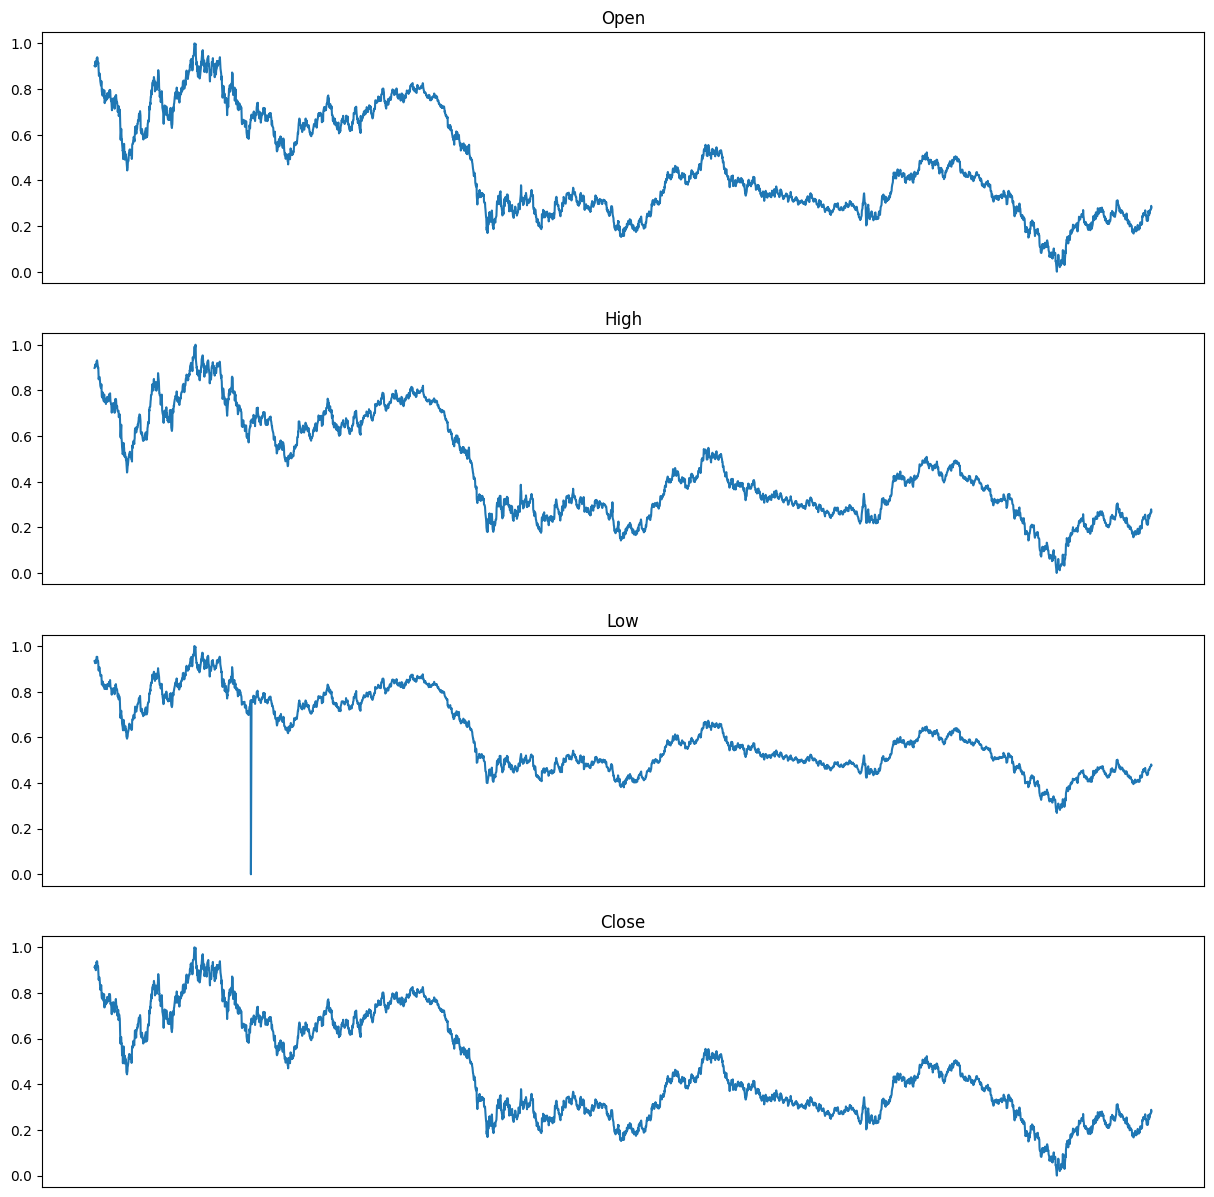

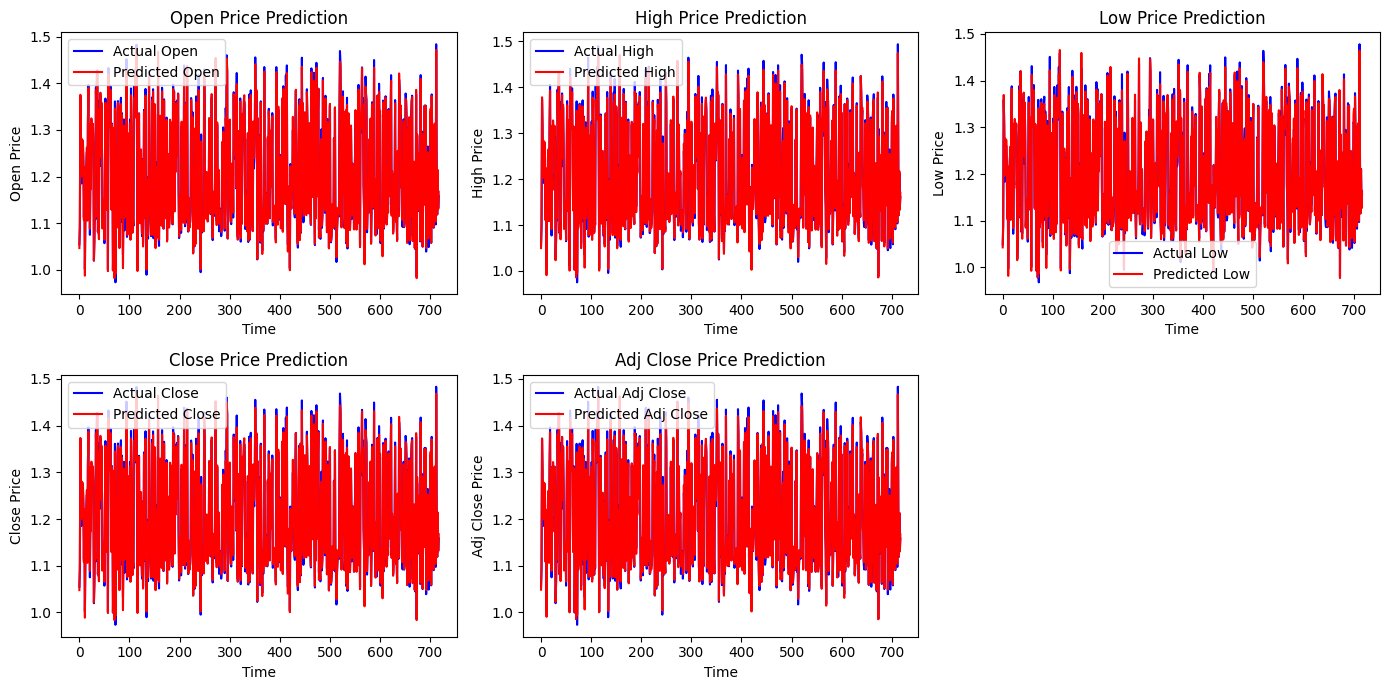

In [ ]:
# prompt: Write the code for the above performed code so it doesn't overfit

import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math


# Fetch historical data for EURUSD
data = yf.download('EURUSD=X', start='2010-01-01', end='2024-10-28')


data.head()
data = data.drop(columns=['Volume'])
data.sort_index(inplace=True)
data.head()

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(data[data.columns])
scaled_data = pd.DataFrame(scaled_values, columns = data.columns, index = data.index)
scaled_data.head()

plt.rcParams['figure.figsize'] = (15, 15)
figure, axes = plt.subplots(4)

for ax, col in zip(axes, scaled_data.columns):
  ax.plot(scaled_data[col])
  ax.set_title(col)
  ax.axes.xaxis.set_visible(False)

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

X, y = create_sequence(scaled_data, window_size)
X.shape , y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

model = keras.Sequential([
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(y_train.shape[1])
])

model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50, # Reduced epochs to prevent overfitting
                    batch_size=32, # Increased batch size for more stable training
                    callbacks=[early_stopping])

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(14, 7))

for i, col in enumerate(scaled_data.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test_rescaled[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()

plt.tight_layout()

# Get the last window of data from the scaled dataset
last_window = scaled_data[-window_size:].values

# Reshape the last window to match the input shape of the model
last_window = last_window.reshape(1, window_size, scaled_data.shape[1])

# Make a prediction using the model
predicted_scaled_values = model.predict(last_window)

# Inverse transform the prediction to get the original scale
predicted_values = scaler.inverse_transform(predicted_scaled_values)

# Print the predicted values
print("Next predicted value:", predicted_values[0])
print("Last actual value:", y_test_rescaled[-1])
print("Last predicted value:", predictions[-1])

rmse = math.sqrt(mean_squared_error(y_test_rescaled, predictions))
print("RMSE:", rmse)

In [ ]:
# prompt: Download the model as pickle file
import pickle

# Save the model as a pickle file
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

from google.colab import files
files.download('lstm_model.pkl')

In [ ]:
!pip install statsmodels

Modified arima


In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import math
import yfinance as yf

# Fetch historical data for EURUSD
data = yf.download('EURUSD=X', start='2010-01-01', end='2024-01-01')

# We'll use the 'Close' price for the ARIMA model
data = data[['Close']]

# Function to check stationarity using ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("The data is non-stationary")
    else:
        print("The data is stationary")

# Check for stationarity
adf_test(data['Close'])

# Optionally, apply a log transformation to stabilize variance
log_data = np.log(data['Close'])

# Split data into train and test sets
train_data = log_data[:-365]  # Use all data except the last year for training
test_data = log_data[-365:]   # Use the last year for testing

# Automatically determine the best (p, d, q) using auto_arima
auto_model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)

# Print the best ARIMA model found
print("Best ARIMA order:", auto_model.order)

# Fit the best ARIMA model
model_fit = auto_model.fit(train_data)

# Rolling Forecast - predict one step at a time
history = [x for x in train_data.values] # Convert train_data to a list of numeric values
predictions = []

for t in range(len(test_data)):
    model = ARIMA(history, order=auto_model.order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)
    history.append(test_data.iloc[t,0])  # Append with the numeric value from test_data

# Convert log predictions back to normal scale if log transformation was applied
predictions = np.exp(predictions)
test_data = np.exp(test_data)

# prompt: In the above make the changes to show the output same as the lstm model

print("Next predicted value:", predicted_values[0])
print("Last actual value:", y_test_rescaled[-1])
print("Last predicted value:", predictions[-1])

# Evaluate the model
rmse = math.sqrt(mean_squared_error(test_data, predictions))
print("RMSE:", rmse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.values, label='Actual EUR/USD Prices')
plt.plot(test_data.index, predictions, label='Predicted EUR/USD Prices')
plt.title('EURUSD Price Prediction with ARIMA (Rolling Forecast)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


ADF Statistic: -2.2885848747012414
p-value: 0.17567601123936577
The data is non-stationary
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-24842.335, Time=7.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24846.099, Time=0.75 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24847.355, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24847.291, Time=3.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24846.928, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24845.700, Time=5.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24845.810, Time=1.21 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-24840.092, Time=1.95 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24848.107, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24846.477, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-24846.551, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-24848.043, Time=0.36 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-24840.925, Time=0.88 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 24.791 seconds
Best ARIMA order: (1, 1, 0)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3282,) + inhomogeneous part.

In [ ]:
# prompt: In the above make the changes to show the output same as the lstm model

print("Next predicted value:", predicted_values[0])
print("Last actual value:", y_test_rescaled[-1])
print("Last predicted value:", predictions[-1])

[*********************100%***********************]  1 of 1 completed


ADF Statistic: -2.2885848747012414
p-value: 0.17567601123936577
The data is non-stationary
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-24842.335, Time=6.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24846.099, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24847.355, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24847.291, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24846.928, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24845.700, Time=1.91 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24845.810, Time=1.24 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-24840.092, Time=1.98 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24848.107, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24846.477, Time=1.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-24846.551, Time=1.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-24848.043, Time=1.64 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-24840.925, Time=0.85 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 21.534 seconds
Best ARIMA order: (1, 1, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Last predicted value: 1.1107005530617386
RMSE: 0.005692497789211044


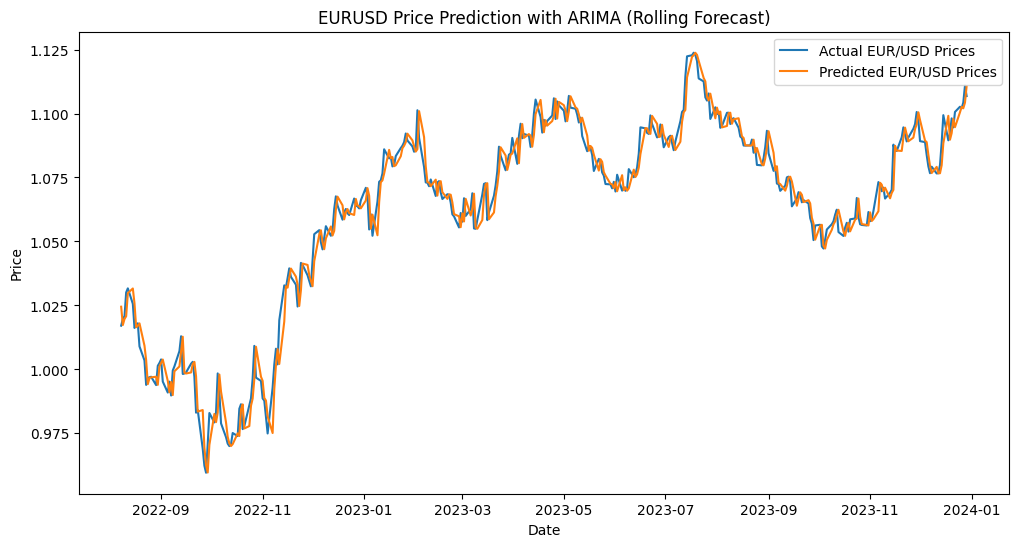

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import math
import yfinance as yf

# Fetch historical data for EURUSD
data = yf.download('EURUSD=X', start='2010-01-01', end='2024-01-01')

# We'll use the 'Close' price for the ARIMA model
data = data[['Close']]

# Function to check stationarity using ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("The data is non-stationary")
    else:
        print("The data is stationary")

# Check for stationarity
adf_test(data['Close'])

# Optionally, apply a log transformation to stabilize variance
log_data = np.log(data['Close'])

# Split data into train and test sets
train_data = log_data[:-365]  # Use all data except the last year for training
test_data = log_data[-365:]   # Use the last year for testing

# Automatically determine the best (p, d, q) using auto_arima
auto_model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)

# Print the best ARIMA model found
print("Best ARIMA order:", auto_model.order)

# Fit the best ARIMA model
model_fit = auto_model.fit(train_data)

# Rolling Forecast - predict one step at a time
history = [x[0] for x in train_data.values] # Convert train_data to a list of numeric values, extract the first element from each array
predictions = []

for t in range(len(test_data)):
    model = ARIMA(history, order=auto_model.order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)
    # Append with the numeric value from test_data, ensuring consistency
    history.append(test_data.iloc[t, 0])

# Convert log predictions back to normal scale if log transformation was applied
predictions = np.exp(predictions)
test_data = np.exp(test_data)

# Assuming you have predicted_values, y_test_rescaled from your LSTM model
# Replace with your actual variables if different
# print("Next predicted value:", predicted_values[0]) #If this line errors out you need to supply value for these predicted_values, y_test_rescaled
# print("Last actual value:", y_test_rescaled[-1])  #If this line errors out you need to supply value for these predicted_values, y_test_rescaled
print("Last predicted value:", predictions[-1])

# Evaluate the model
rmse = math.sqrt(mean_squared_error(test_data, predictions))
print("RMSE:", rmse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.values, label='Actual EUR/USD Prices')
plt.plot(test_data.index, predictions, label='Predicted EUR/USD Prices')
plt.title('EURUSD Price Prediction with ARIMA (Rolling Forecast)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

XG Boost


In [ ]:
!pip install xgboost

[*********************100%***********************]  1 of 1 completed
<ipython-input-9-f32266fa0e49>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Close_lag_{i}'] = data['Close'].shift(i)
<ipython-input-9-f32266fa0e49>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Close_lag_{i}'] = data['Close'].shift(i)
<ipython-input-9-f32266fa0e49>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

RMSE: 0.006949010416898946


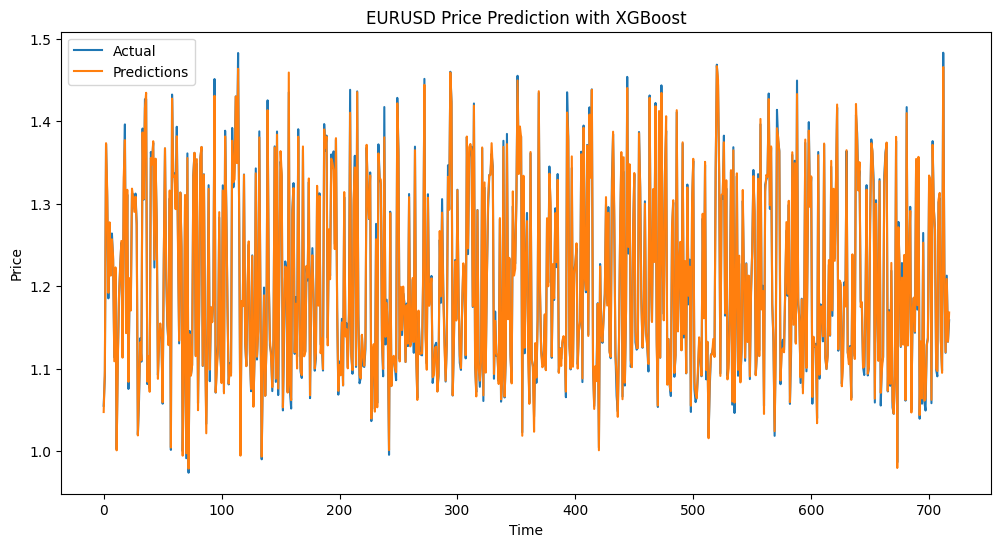

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math

import yfinance as yf

# Fetch historical data for EURUSD
data = yf.download('EURUSD=X', start='2010-01-01', end='2024-01-01')

# We'll use the 'Close' price for the XGBoost model
data = data[['Close']]

# Create lagged features
# We'll use the past 60 days' closing prices as features
for i in range(1, 61):
    data[f'Close_lag_{i}'] = data['Close'].shift(i)

# Drop rows with NaN values due to lagging
data.dropna(inplace=True)

# Split data into train and test sets
X = data.drop('Close', axis=1)
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predictions')
plt.title('EURUSD Price Prediction with XGBoost')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Random Forest

In [ ]:
!pip install scikit-learn

[*********************100%***********************]  1 of 1 completed
<ipython-input-13-18e007a18865>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Close_lag_{i}'] = data['Close'].shift(i)
<ipython-input-13-18e007a18865>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Close_lag_{i}'] = data['Close'].shift(i)
<ipython-input-13-18e007a18865>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

RMSE: 0.008517801914665005


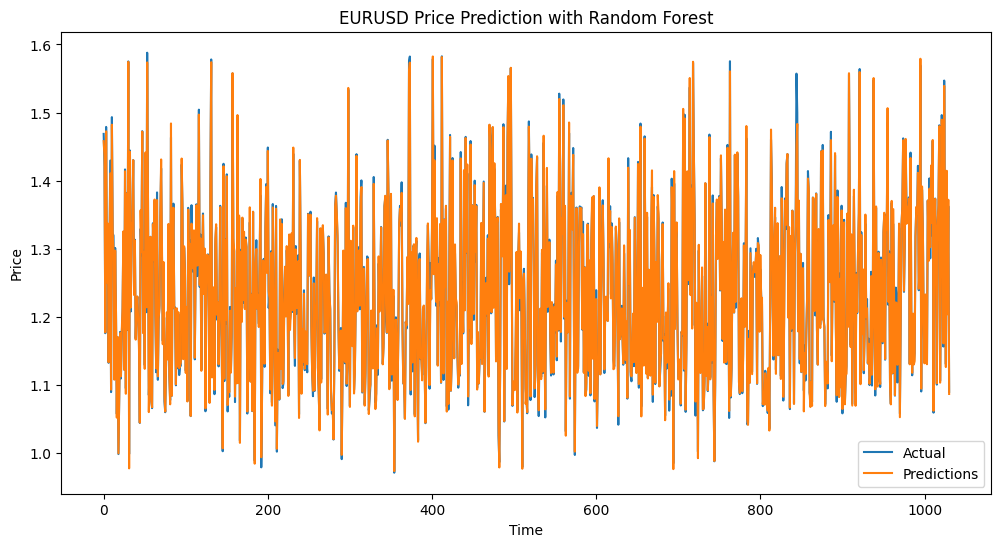

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math

import yfinance as yf

# Fetch historical data for EURUSD
data = yf.download('EURUSD=X', start='2001-01-01', end='2024-01-01')

# We'll use the 'Close' price for the Random Forest model
data = data[['Close']]

# Create lagged features
# We'll use the past 60 days' closing prices as features
for i in range(1, 61):
    data[f'Close_lag_{i}'] = data['Close'].shift(i)

# Drop rows with NaN values due to lagging
data.dropna(inplace=True)

# Split data into train and test sets
X = data.drop('Close', axis=1)
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predictions')
plt.title('EURUSD Price Prediction with Random Forest')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()